In [35]:
import pandas as pd
from pandas import unique
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from utils.new_columns_fiorenzo import add_speed_direction_to_summary, pixel_meters_ratio, add_day_night_to_summary, classify_vehicle_types
from utils.plots_fiorenzo import visualize_classification, vehicle_count_over_time_histogram, average_speed_by_weekday_and_hour, speeding_vehicles_histogram
from data_pipeline import process_all_sessions
from utils.loader import load_data_from_database

In [36]:
final_summary = None
summary_loaded = False
print("Do you want to load processed_traffic_data.csv?")
if input("Type 'y' to proceed: ").lower() == 'y':
    final_summary = pd.read_csv('../data/processed_traffic_data.csv')
    summary_loaded = True

Do you want to load processed_traffic_data.csv?


In [37]:
if not summary_loaded:
    print("Do you want to load data from the database? This may take a while.")
    if input("Type 'y' to proceed: ").lower() == 'y':
        df = load_data_from_database()
        df = df.sort_values(['date_time', 'frame_id'])
    else:
        df = pd.read_csv("../data/raw_traffic_data.csv", parse_dates=['date_time'])
        df = df.sort_values(['date_time', 'frame_id'])

In [38]:
if not summary_loaded:
    df['session_id'] = (
        (df['frame_id'].diff() < 0)
    ).cumsum()

In [39]:
if not summary_loaded:
    final_summary = process_all_sessions(df)
    print(final_summary.head())
    print(unique(final_summary['category']))
    final_summary.to_csv('"../data/raw_traffic_data.csv"', index=False)
    final_summary_viable = final_summary[final_summary['category'].isin(['Perfect', 'Partial', 'Merged'])]

In [40]:
## Filter time
final_summary['t_start'] = pd.to_datetime(final_summary['t_start'])
final_summary['t_end'] = pd.to_datetime(final_summary['t_end'])

start_date = pd.to_datetime('2025-12-01')
end_date = pd.to_datetime('2026-01-01')

final_summary = final_summary[(final_summary['t_start'] >= start_date) & (final_summary['t_start'] < end_date)]
print(f"Filtered data from {start_date.date()} to {end_date.date()}")
print(f"Remaining records: {len(final_summary)}")
print(final_summary)

Filtered data from 2025-12-01 to 2026-01-01
Remaining records: 489606
        session_id         vehicle_id  y_start  y_end      w_mean      w_std  \
21346            2  [np.int64(19309)]      273    273  101.000000        NaN   
21347            2  [np.int64(19310)]      273    273   99.000000        NaN   
21348            2            [19311]      276    276   73.000000        NaN   
21349            2            [19312]      272    272   97.600000  18.662797   
21350            2            [19313]      275    275   68.000000        NaN   
...            ...                ...      ...    ...         ...        ...   
510947          15            [93092]        0      0   41.000000        NaN   
510948          15            [93093]      279    274   92.384615   9.853413   
510949          15            [93094]      275    275   73.000000        NaN   
510950          15            [93095]      278    273   76.000000  21.213203   
510951          15            [93096]       38    

In [41]:
## Duration, Speed and Direction
final_summary['duration'] = (final_summary['t_end'] - final_summary['t_start']).dt.total_seconds()

final_summary = add_speed_direction_to_summary(final_summary)

print(final_summary.head())

       session_id         vehicle_id  y_start  y_end  w_mean      w_std  \
21346           2  [np.int64(19309)]      273    273   101.0        NaN   
21347           2  [np.int64(19310)]      273    273    99.0        NaN   
21348           2            [19311]      276    276    73.0        NaN   
21349           2            [19312]      272    272    97.6  18.662797   
21350           2            [19313]      275    275    68.0        NaN   

       w_start  w_end  h_mean     h_std  ...      h_cv  movement_efficiency  \
21346    101.0  101.0    17.0       NaN  ...  0.000000             0.058621   
21347     99.0   99.0    17.0       NaN  ...  0.000000             0.058621   
21348     73.0   73.0    14.0       NaN  ...  0.000000             0.048276   
21349    100.0  100.0    17.8  1.788854  ...  0.100497             0.012414   
21350     68.0   68.0    15.0       NaN  ...  0.000000             0.051724   

       category unified_id  duration  velocity_x_px_seconds  \
21346     G

In [42]:
## Create columns size_mean and h/w_mean ratio
final_summary['size_mean'] = final_summary['w_mean'] * final_summary['h_mean']
final_summary['h_w_mean_ratio'] = final_summary['h_mean'] / final_summary['w_mean']
print(final_summary.head())

       session_id         vehicle_id  y_start  y_end  w_mean      w_std  \
21346           2  [np.int64(19309)]      273    273   101.0        NaN   
21347           2  [np.int64(19310)]      273    273    99.0        NaN   
21348           2            [19311]      276    276    73.0        NaN   
21349           2            [19312]      272    272    97.6  18.662797   
21350           2            [19313]      275    275    68.0        NaN   

       w_start  w_end  h_mean     h_std  ...  category  unified_id  duration  \
21346    101.0  101.0    17.0       NaN  ...     Ghost         NaN  0.000000   
21347     99.0   99.0    17.0       NaN  ...     Ghost         NaN  0.000000   
21348     73.0   73.0    14.0       NaN  ...     Ghost         NaN  0.000000   
21349    100.0  100.0    17.8  1.788854  ...     Ghost         NaN  0.152312   
21350     68.0   68.0    15.0       NaN  ...     Ghost         NaN  0.000000   

      velocity_x_px_seconds velocity_y_px_seconds  velocity_x_km_h  

In [43]:
## Mean height, width and size in meters
final_summary['h_mean_meters'] = final_summary['h_mean'] / pixel_meters_ratio
final_summary['w_mean_meters'] = final_summary['w_mean'] / pixel_meters_ratio
final_summary['size_mean_meters'] = final_summary['size_mean'] / pixel_meters_ratio
print(final_summary)

        session_id         vehicle_id  y_start  y_end      w_mean      w_std  \
21346            2  [np.int64(19309)]      273    273  101.000000        NaN   
21347            2  [np.int64(19310)]      273    273   99.000000        NaN   
21348            2            [19311]      276    276   73.000000        NaN   
21349            2            [19312]      272    272   97.600000  18.662797   
21350            2            [19313]      275    275   68.000000        NaN   
...            ...                ...      ...    ...         ...        ...   
510947          15            [93092]        0      0   41.000000        NaN   
510948          15            [93093]      279    274   92.384615   9.853413   
510949          15            [93094]      275    275   73.000000        NaN   
510950          15            [93095]      278    273   76.000000  21.213203   
510951          15            [93096]       38      0   57.800000  11.723943   

        w_start  w_end     h_mean     h

In [44]:
## Day/Night difference
final_summary = add_day_night_to_summary(final_summary)
print(final_summary)

        session_id         vehicle_id  y_start  y_end      w_mean      w_std  \
21346            2  [np.int64(19309)]      273    273  101.000000        NaN   
21347            2  [np.int64(19310)]      273    273   99.000000        NaN   
21348            2            [19311]      276    276   73.000000        NaN   
21349            2            [19312]      272    272   97.600000  18.662797   
21350            2            [19313]      275    275   68.000000        NaN   
...            ...                ...      ...    ...         ...        ...   
510947          15            [93092]        0      0   41.000000        NaN   
510948          15            [93093]      279    274   92.384615   9.853413   
510949          15            [93094]      275    275   73.000000        NaN   
510950          15            [93095]      278    273   76.000000  21.213203   
510951          15            [93096]       38      0   57.800000  11.723943   

        w_start  w_end     h_mean     h

In [45]:
## Apply vehicle classification
# Classify vehicles using automatic data-driven thresholds
final_summary = classify_vehicle_types(final_summary, verbose=True)

'''
# Optional: Use custom thresholds if you want to fine-tune the classification
# Uncomment and adjust values as needed:
# final_summary_with_class = classify_vehicle_types(
#     final_summary_viable,
#     size_threshold=7500,      # Threshold for area (w_mean * h_mean)
#     width_threshold=70,        # Threshold for width
#     height_threshold=140,      # Threshold for height
#     verbose=True
# )
'''
# Show sample results
print("\n" + "="*70)
print("SAMPLE CLASSIFIED VEHICLES")
print("="*70)
print("\nFirst 10 vehicles:")
print(final_summary[['vehicle_id', 'w_mean', 'h_mean', 'size_mean', 'h_w_mean_ratio', 'Class']].head(10).to_string(index=False))

print("\n" + "="*70)
print("CLASS DISTRIBUTION BY TRACK CATEGORY")
print("="*70)
crosstab = pd.crosstab(final_summary['category'],
                       final_summary['Class'],
                       margins=True, margins_name='Total')
print(crosstab)
print("\n" + "="*70)

VEHICLE CLASSIFICATION RESULTS - DAY

Vehicles classified during Day: 284306

Classification threshold used for Day:
  Height threshold:          120.00 pixels

Class distribution for Day:
  Car   : 263720 ( 92.8%)
  Truck : 20586 (  7.2%)

Duration threshold calculated from Day data:
  Mean Car duration:           0.89 seconds
  Mean Truck duration:         1.79 seconds
  Calculated threshold:        1.34 seconds (midpoint)

VEHICLE CLASSIFICATION RESULTS - NIGHT

Vehicles classified during Night: 205300

Classification thresholds used for Night (OR logic):
  Height threshold:          120.00 pixels
  Width threshold:           110.00 pixels
  Duration threshold:          1.34 seconds

Trucks classified by criterion:
  By height:               17559
  By width (not height):   32114
  By duration (not h/w):   22479

Class distribution for Night:
  Car   : 205193 ( 99.9%)
  Truck :  107 (  0.1%)

OVERALL CLASSIFICATION SUMMARY

Total vehicles classified: 489606

Overall class distributi

Total


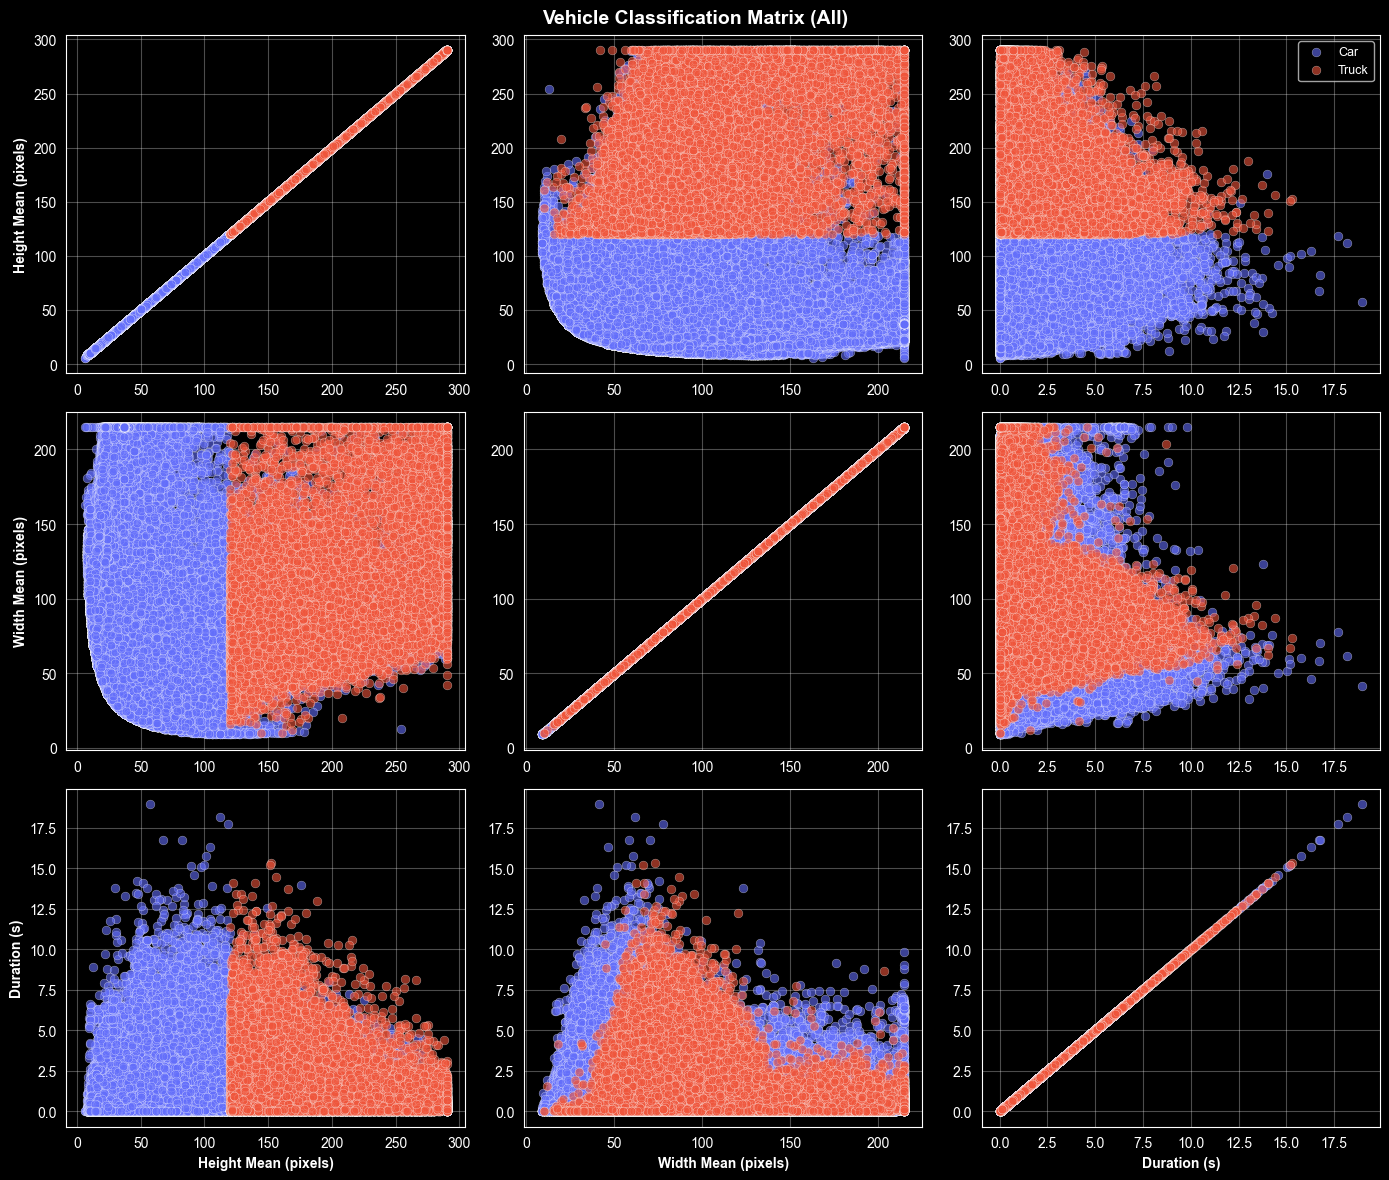


CLASSIFICATION SUMMARY (All)

Total vehicles: 489606
  Cars:   468913 (95.8%)
  Trucks: 20693 (4.2%)

Day


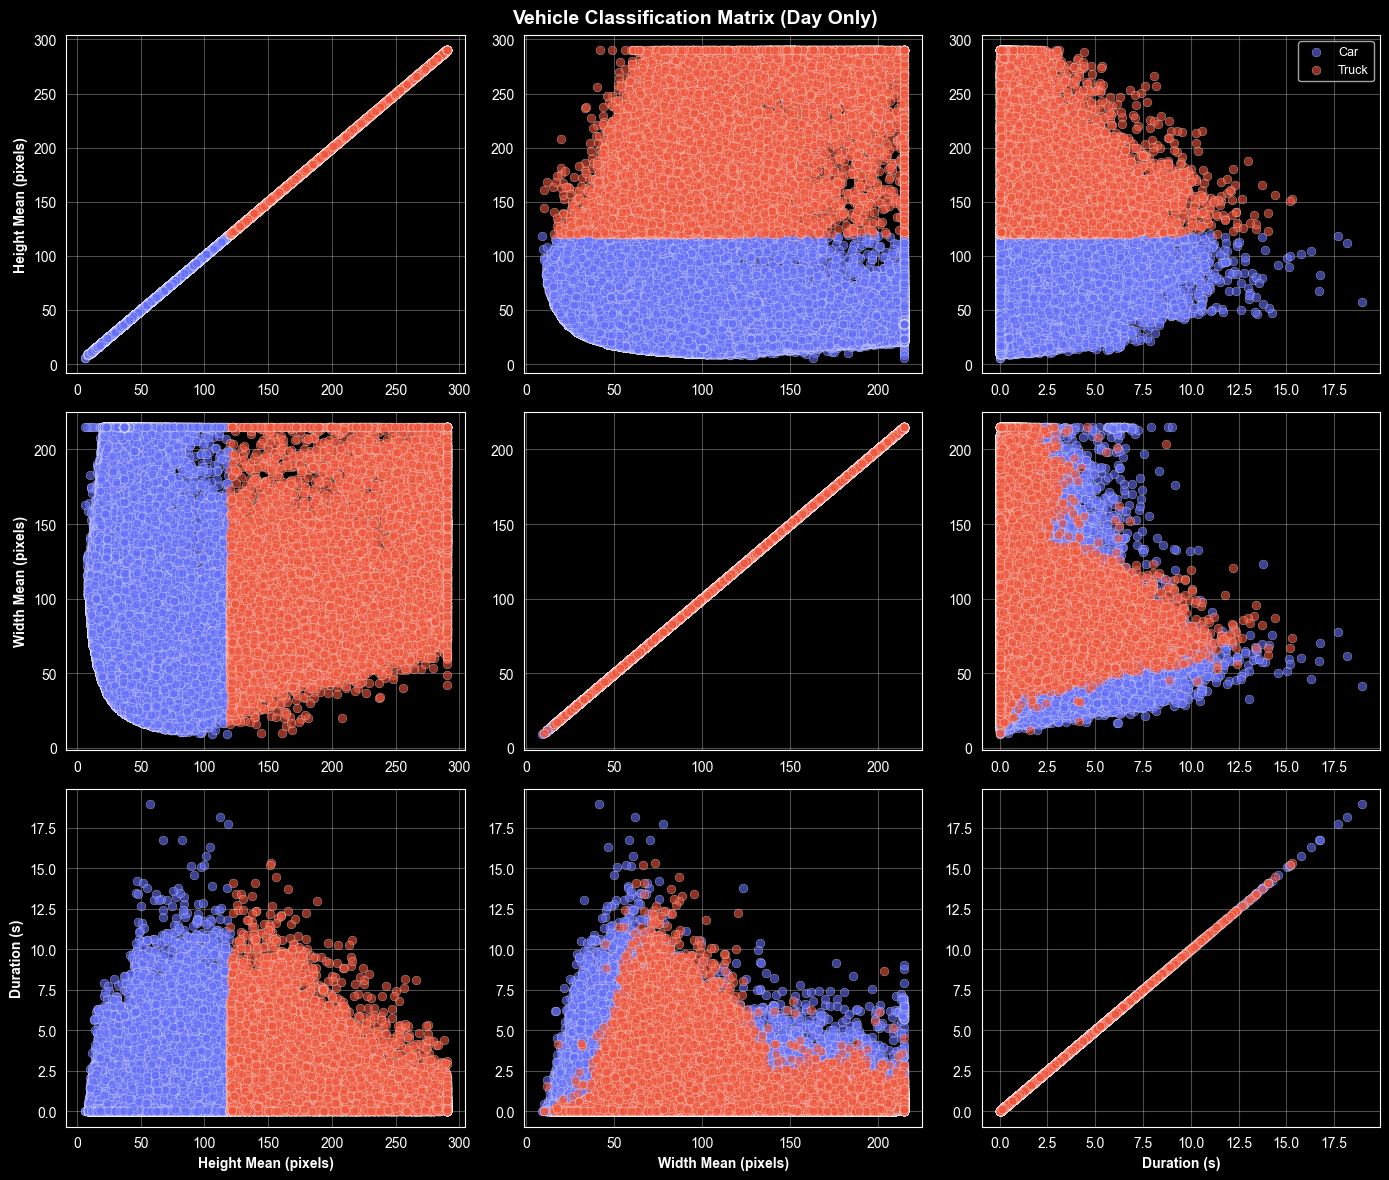


CLASSIFICATION SUMMARY (Day Only)

Total vehicles: 284306
  Cars:   263720 (92.8%)
  Trucks: 20586 (7.2%)

Night


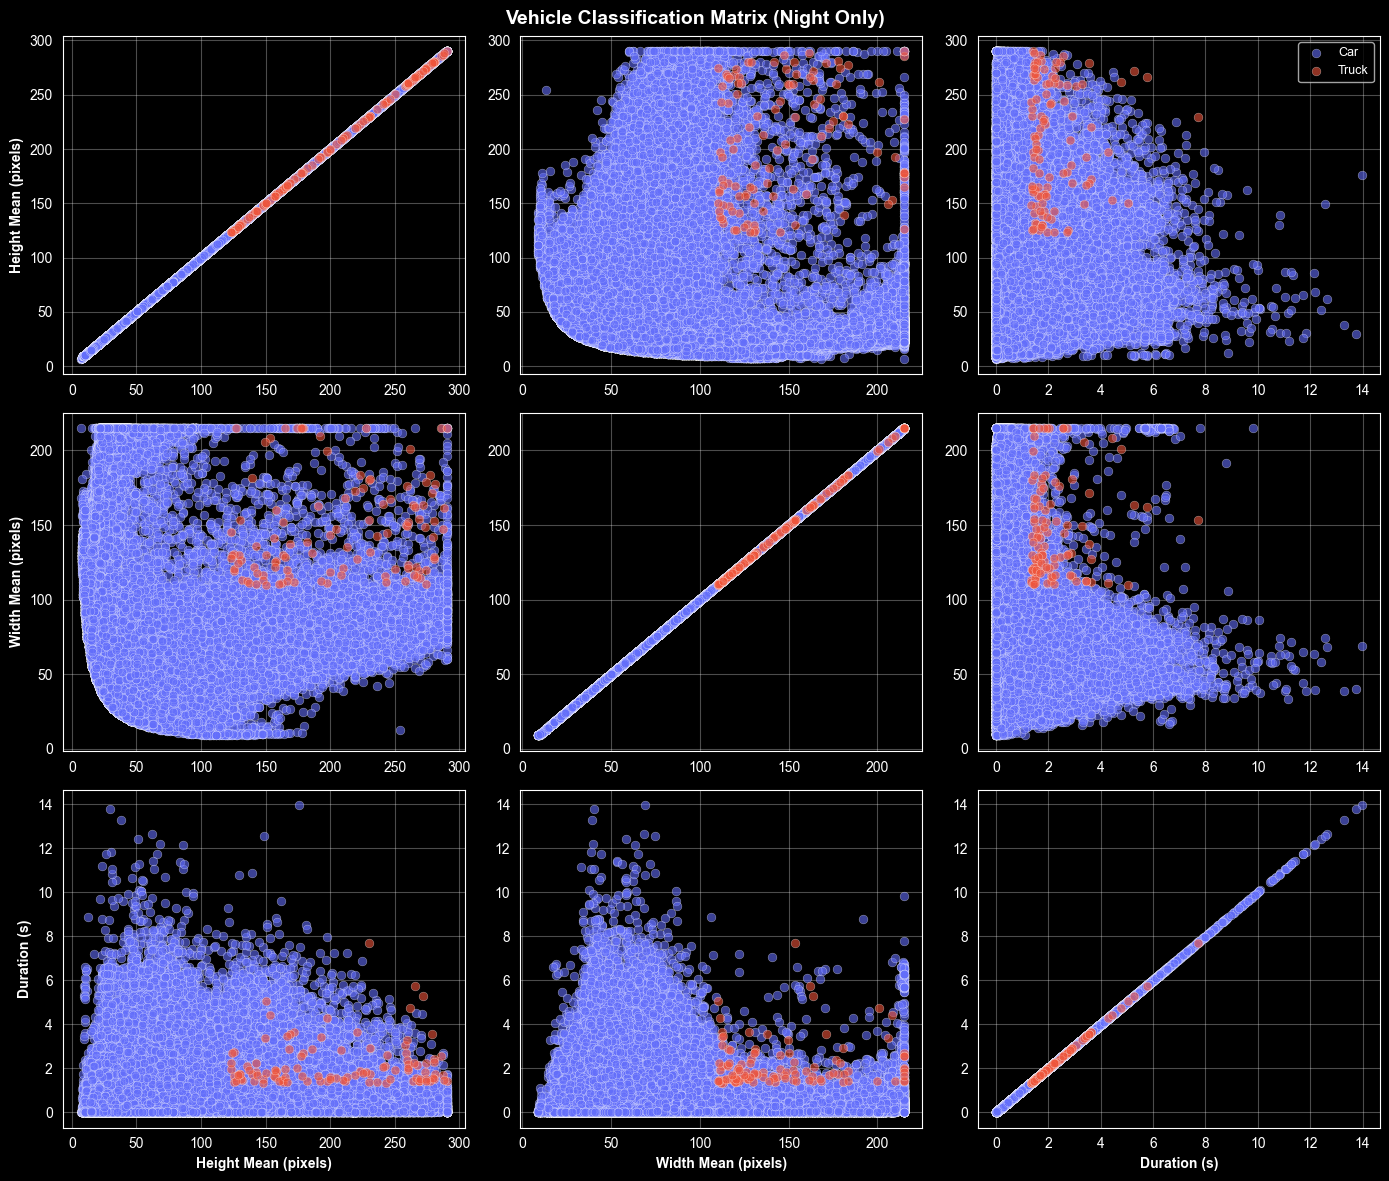


CLASSIFICATION SUMMARY (Night Only)

Total vehicles: 205300
  Cars:   205193 (99.9%)
  Trucks: 107 (0.1%)



In [46]:
## Visualize vehicle classification
print("Total")
visualize_classification(final_summary, show_plot=True)
print("Day")
visualize_classification(final_summary, show_plot=True, day_only=True)
print("Night")
visualize_classification(final_summary, show_plot=True, night_only=True)

/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:168: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',
/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:168: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',
/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.

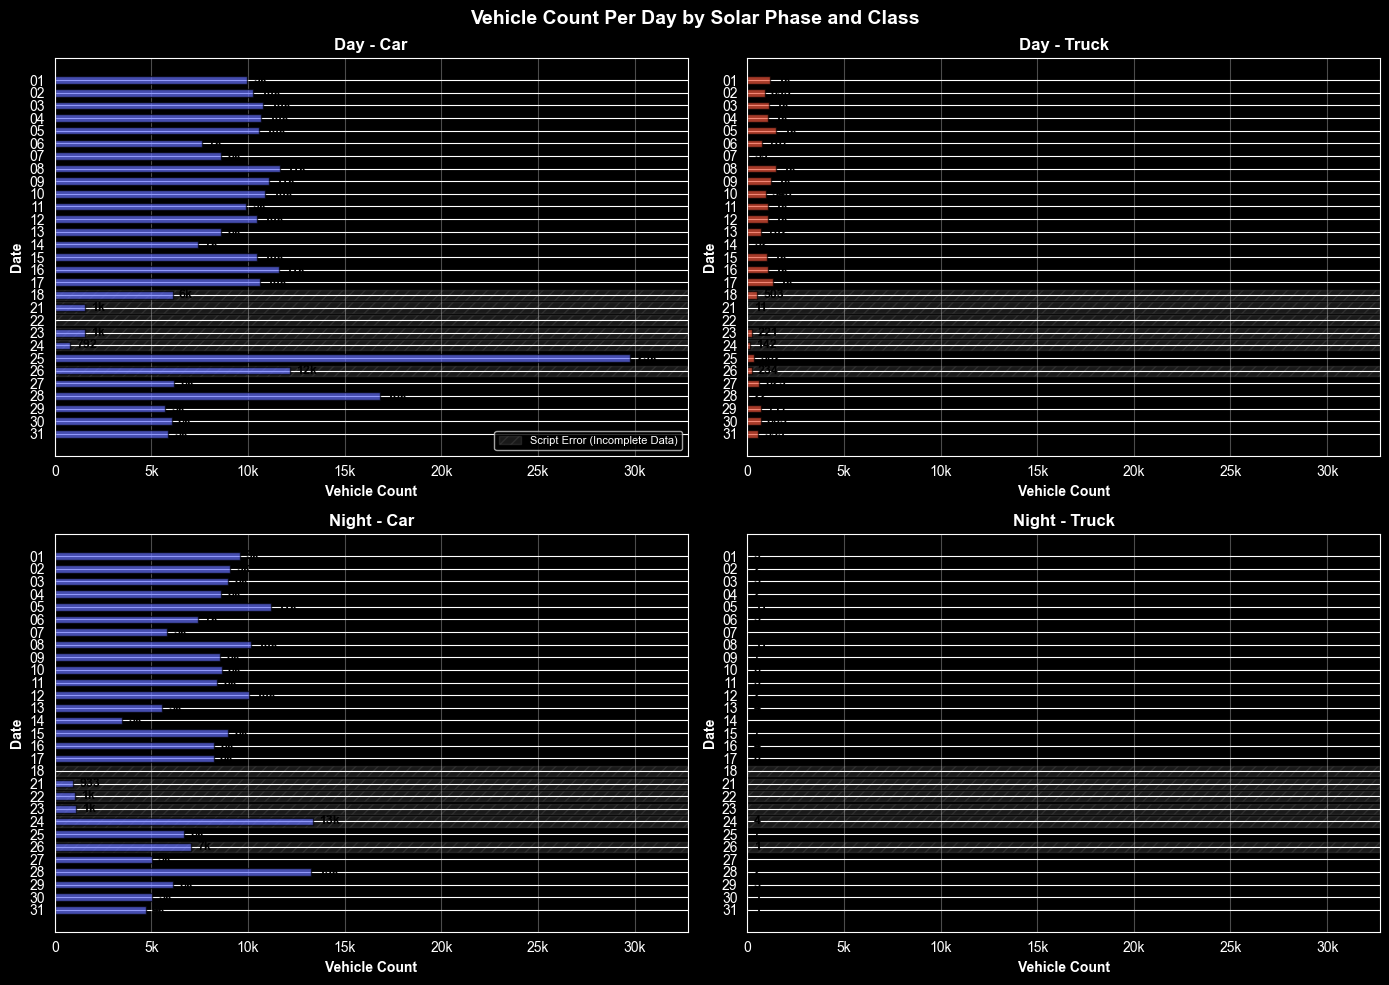

VEHICLE COUNT STATISTICS

Total vehicles: 489606

Count by Solar Phase and Class:
Class           Car  Truck
solar_phase               
Day          263720  20586
Night        205193    107

Count per day by Solar Phase and Class:
Class                     Car  Truck
date       solar_phase              
2025-12-01 Day           9951   1194
           Night         9569      9
2025-12-02 Day          10281    893
           Night         9060      2
2025-12-03 Day          10789   1105
           Night         8980      5
2025-12-04 Day          10691   1060
           Night         8611      2
2025-12-05 Day          10557   1503
           Night        11187     11
2025-12-06 Day           7603    787
           Night         7396      5
2025-12-07 Day           8616     59
           Night         5813      0
2025-12-08 Day          11657   1481
           Night        10134     11
2025-12-09 Day          11060   1218
           Night         8571      7
2025-12-10 Day          10898

In [47]:
## Distribution plot
vehicle_count_over_time_histogram(final_summary, show_plot=True)

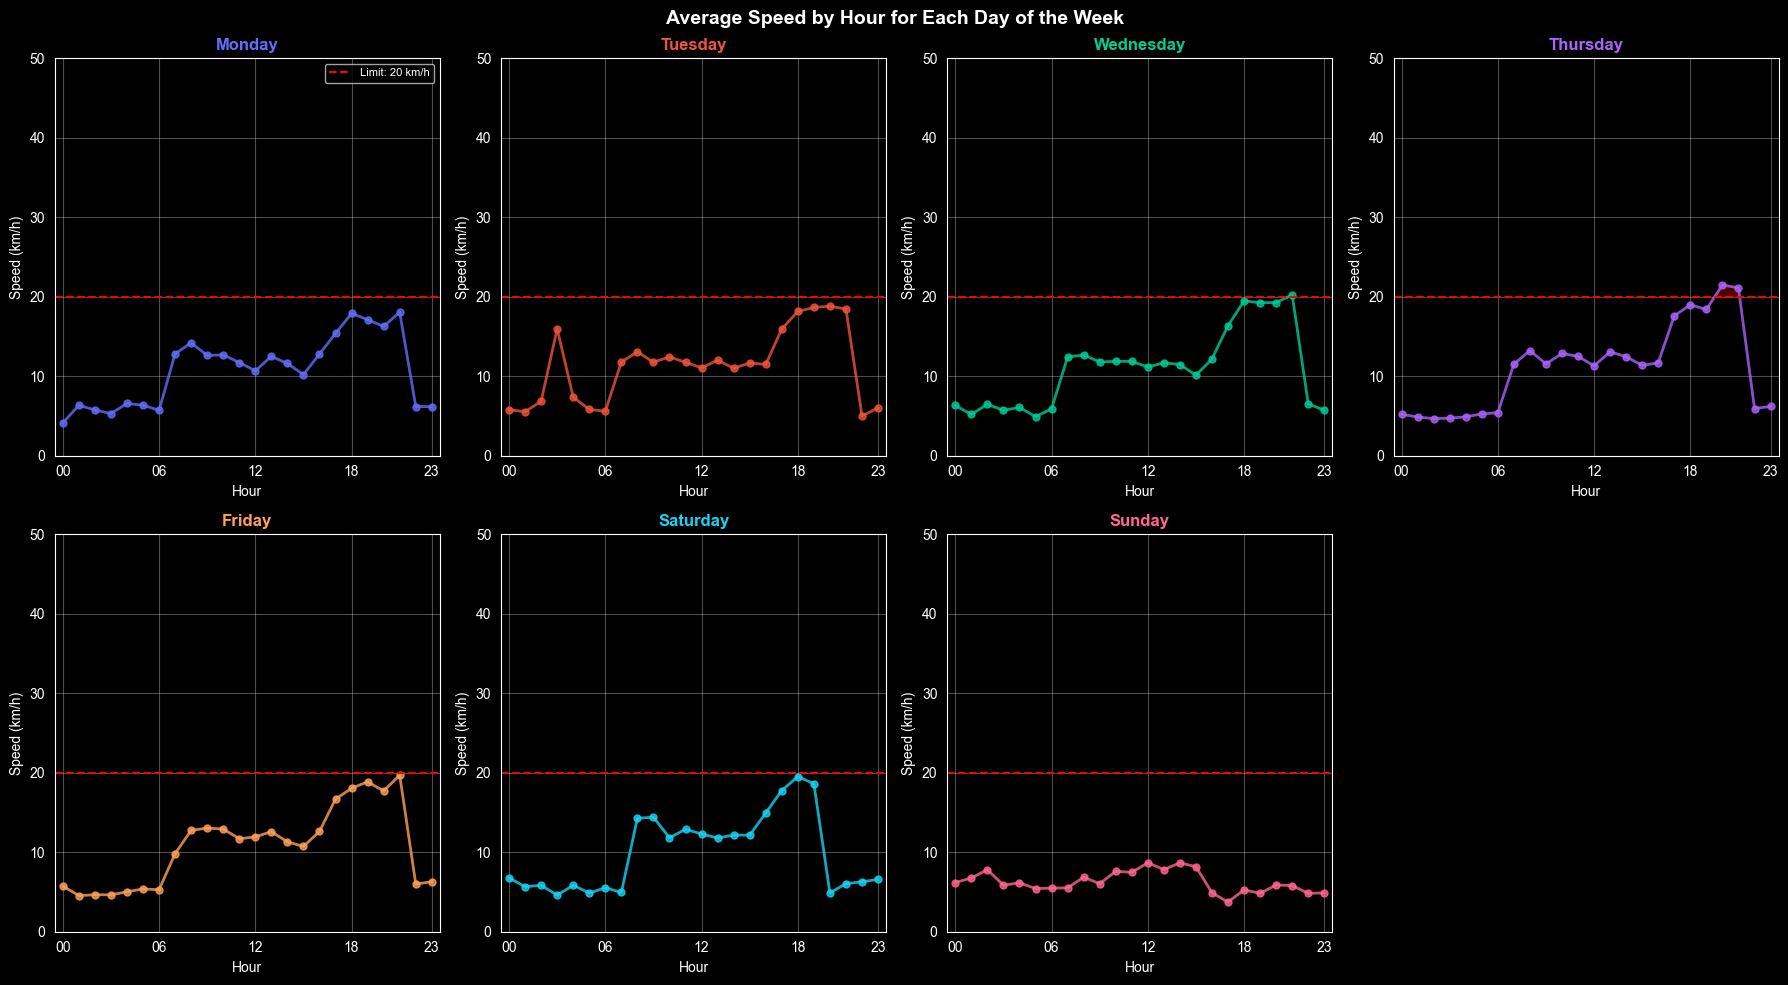

AVERAGE SPEED BY DAY OF WEEK AND HOUR (km/h)

Pivot Table (rows=hour, columns=day of week):
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
hour                                                                       
0              4.12     5.80       6.32      5.21    5.75      6.77    6.19
1              6.35     5.53       5.19      4.87    4.54      5.67    6.76
2              5.75     6.84       6.47      4.67    4.66      5.84    7.81
3              5.30    15.97       5.70      4.71    4.64      4.60    5.85
4              6.57     7.36       6.08      4.89    5.02      5.85    6.16
5              6.36     5.83       4.91      5.25    5.39      4.87    5.42
6              5.71     5.58       5.89      5.41    5.28      5.54    5.49
7             12.82    11.78      12.41     11.51    9.83      4.94    5.51
8             14.20    13.07      12.66     13.22   12.75     14.28    6.87
9             12.62    11.76      11.80     11.54   13.04     14.41    6

In [48]:
## Average speed by weekday and hour
average_speed_by_weekday_and_hour(final_summary, show_plot=True)

/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:168: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',


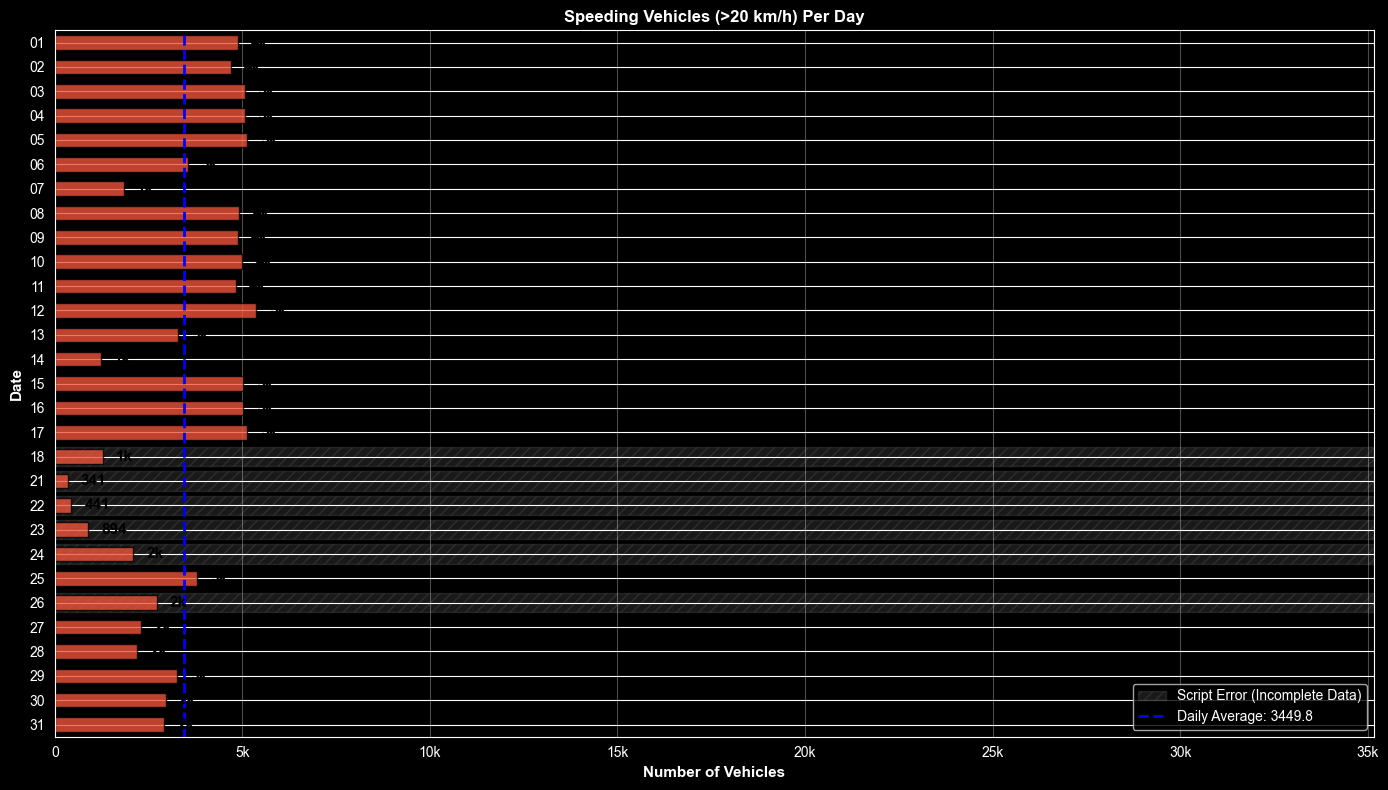

/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:168: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',


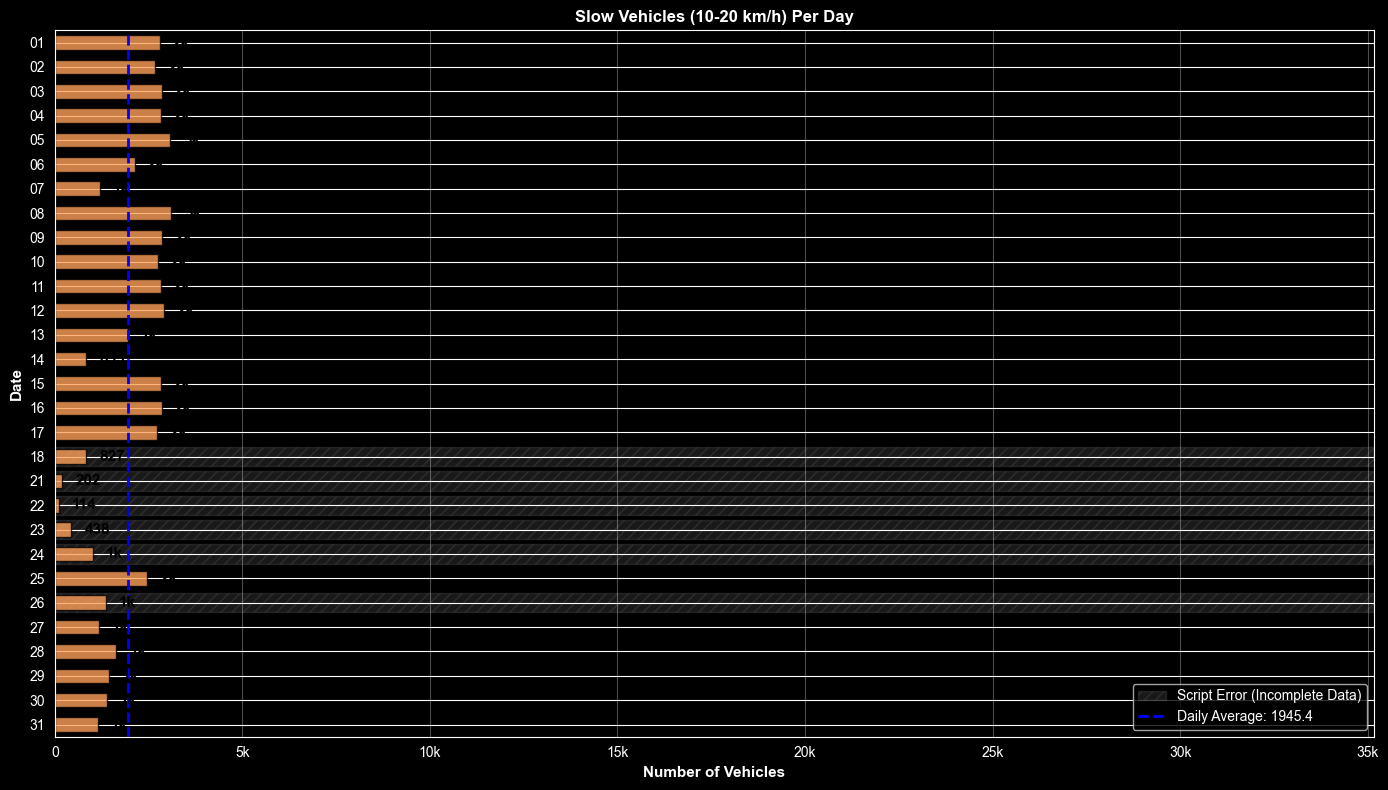

/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:168: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',


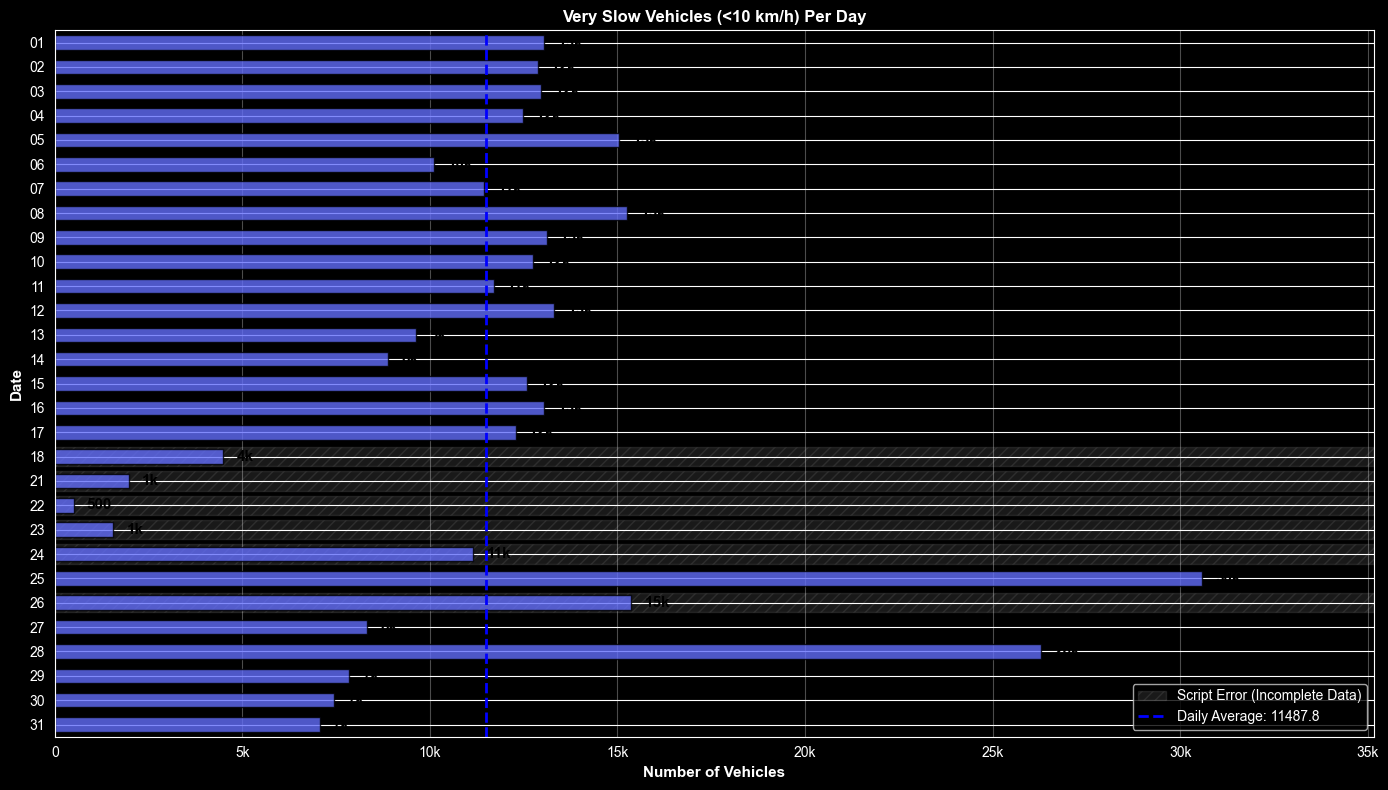

VEHICLE SPEED CATEGORY STATISTICS

Data collection period: 2025-12-31 to 2025-12-01
Total days: 29
Total vehicles: 489606

Speeding (>20 km/h):
  Total: 100043 (20.4%)
  Daily average: 3449.8
  Maximum: 5360 (on 2025-12-12)
  Minimum: 341 (on 2025-12-21)

Slow (10-20 km/h):
  Total: 56417 (11.5%)
  Daily average: 1945.4
  Maximum: 3105 (on 2025-12-08)
  Minimum: 114 (on 2025-12-22)

Very Slow (<10 km/h):
  Total: 333146 (68.0%)
  Daily average: 11487.8
  Maximum: 30577 (on 2025-12-25)
  Minimum: 500 (on 2025-12-22)



In [49]:
## Speeding vehicles histogram
speeding_vehicles_histogram(final_summary, show_plot=True)  # Adjust speed limit as needed